In [93]:
# IMPORTS
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn as sl
%matplotlib inline
import scipy as sc
import math as ma
from scipy import linalg, optimize, constants, interpolate, special, stats
from math import exp, pow, sqrt, log
from pandas import DataFrame

import keras
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD

import seaborn as sns 
import statsmodels.api as sm
import statsmodels.stats.api as sms

EarLobe = pd.read_csv('datensatz/earLobe.csv')
InnerArm = pd.read_csv('datensatz/innerArm.csv')
Vein = pd.read_csv('datensatz/vein.csv')
ThumbNail = pd.read_csv('datensatz/thumbNail.csv')


Alle Datensätze werden eingelesen, gesplittet und als array gespeichert. 

In [94]:
## THUMBNAIL 
ThumbNail = open('datensatz/thumbNail.csv', 'r') 
ThumbNail_Data = ThumbNail.readlines()
ThumbNail_inputs = np.empty([21,3160])

k=0
for i in range(1, len(ThumbNail_Data)):
    ThumbNail_line = ThumbNail_Data[i].split(',')
    ThumbNail_input = np.asfarray(ThumbNail_line[2:])

    ThumbNail_inputs[k] = ThumbNail_input
    k+=1
    pass


## VEINS 
Vein = open('datensatz/vein.csv', 'r') 
Vein_Data = Vein.readlines()
Vein_inputs = np.empty([21,3160])

k=0
for i in range(1, len(Vein_Data)):
    Vein_line = Vein_Data[i].split(',')
    Vein_input = np.asfarray(Vein_line[2:])

    Vein_inputs[k] = Vein_input
    k+=1
    pass


## EARLOBE 
EarLobe = open('datensatz/earLobe.csv', 'r') 
EarLobe_Data = EarLobe.readlines()
EarLobe_inputs = np.empty([21,3160])

k=0
for i in range(1, len(EarLobe_Data)):
    EarLobe_line = EarLobe_Data[i].split(',')
    EarLobe_input = np.asfarray(EarLobe_line[2:])
    EarLobe_inputs[k] = EarLobe_input
    k+=1
    pass

## INNERARM
InnerArm = open('datensatz/innerArm.csv', 'r') 
InnerArm_Data = InnerArm.readlines()
InnerArm_inputs = np.empty([21,3160])

k=0
for i in range(1, len(InnerArm_Data)):
    InnerArm_line = InnerArm_Data[i].split(',')
    InnerArm_input = np.asfarray(InnerArm_line[2:])
    InnerArm_inputs[k] = InnerArm_input
    k+=1
    pass


Datensätze werden geplottet, jeweils ein gesunder und ein kranker Patient pro Körperteil in einm Subplot.

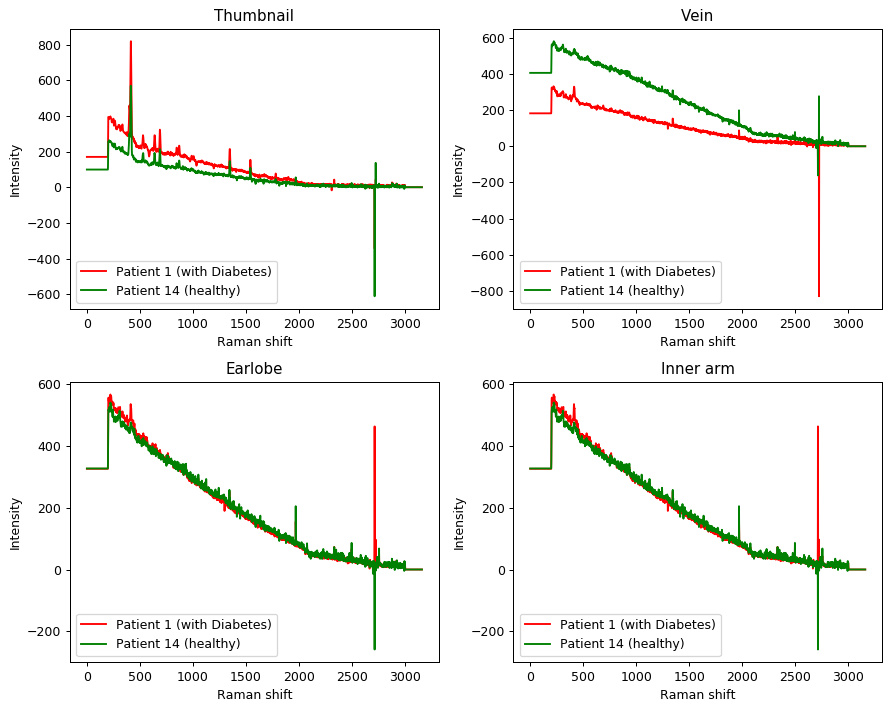

In [95]:
# Plot für Patient 1,2 (transponiert)

plt.figure(figsize=(10, 8), dpi=90)

plt.subplot(221);  

plt.plot(ThumbNail_inputs[1].T, 'r', label="Patient 1 (with Diabetes)")
plt.plot(ThumbNail_inputs[14].T, 'g', label="Patient 14 (healthy)")
plt.title('Thumbnail');
plt.legend(loc='lower left');
plt.xlabel('Raman shift');
plt.ylabel('Intensity'); 

plt.subplot(222);  
plt.plot(Vein_inputs[1].T, 'r', label="Patient 1 (with Diabetes)")
plt.plot(Vein_inputs[14].T, 'g', label="Patient 14 (healthy)")
plt.title('Vein');
plt.legend(loc='lower left');
plt.xlabel('Raman shift');
plt.ylabel('Intensity'); 

plt.subplot(223);  
plt.plot(EarLobe_inputs[1].T, 'r', label="Patient 1 (with Diabetes)")
plt.plot(EarLobe_inputs[14].T, 'g', label="Patient 14 (healthy)")
plt.title('Earlobe');
plt.legend(loc='lower left');
plt.xlabel('Raman shift');
plt.ylabel('Intensity'); 

plt.subplot(224);  
plt.plot(InnerArm_inputs[1].T, 'r', label="Patient 1 (with Diabetes)")
plt.plot(InnerArm_inputs[14].T, 'g', label="Patient 14 (healthy)")
plt.title('Inner arm');
plt.legend(loc='lower left');
plt.xlabel('Raman shift');
plt.ylabel('Intensity');

plt.tight_layout();

plt.savefig('diabetesMellitus.png')



Vein Datensatz wird eingelesen und die Dimension ausgegeben, in dem Fall 22 Stück. 20 Patienten + Header + unsinnige Zeile "ramanShift..". Datensatz haben wir selber gesplittet (16 zu 4) in Trainings und Testdaten. Diese werden ebenfalls eingelesen und die Dimension ausgegeben. (Jeweils -1 wegen Header)

In [96]:
vein_data_file = open('datensatz/vein.csv', 'r')
vein_data_list = vein_data_file.readlines() 
vein_data_file.close()

#Check der Dimensionen (20 Patienten)
print('gesamter Datensatz: ' + str(len(vein_data_list)))


vein_data_file_train = open('datensatz/vein_train.csv', 'r')
vein_data_list_train = vein_data_file_train.readlines() 
#vein_data_file_train.close()

vein_data_file_test = open('datensatz/vein_test.csv', 'r')
vein_data_list_test = vein_data_file_test.readlines() 
#vein_data_file_test.close()

#Check der Dimensionen (22 Patienten)
print('Trainingsdaten gesplittet: ' + str(len(vein_data_list_train)))
print('Testdaten gesplittet: ' + str(len(vein_data_list_test)))



gesamter Datensatz: 22
Trainingsdaten gesplittet: 15
Testdaten gesplittet: 7


Nun wird über die Zeilen der beiden csv Dateien iteriert und jeder Eintrag entsprechend dem vorkommenden Maxium skaliert und geshiftet. 

In [97]:
inputs_train = np.empty([14,3161])
targets_train = np.empty([14,2]) 

k = 0
for record in vein_data_file_train: 
    all_values_train = record.split(',')
    inputs_t = (np.asfarray(all_values_train[1:]) / 752.0 * 0.999) + 0.0001
    
    numberoutputs = 2
    targets_t = np.zeros(numberoutputs) + 0.0001
    targets_t[int(all_values_train[0])] = 0.999
  
    inputs_train[k]  = inputs_t
    targets_train[k] = targets_t
    
    k += 1
    pass

In [98]:
inputs_test = np.empty([6,3161])
targets_test = np.empty([6,2])

k = 0
for record in vein_data_file_test:  
    all_values_test = record.split(',')
    inputs_te = (np.asfarray(all_values_test[1:]) / 780.0 * 0.999) + 0.0001
    
    numberoutputs_test = 2
    targets_te = np.zeros(numberoutputs_test) + 0.0001
    targets_te[int(all_values_test[0])] = 0.999
  
    inputs_test[k]  = inputs_te
    targets_test[k] = targets_te
    
    k += 1
    pass

Daten werden gespeichert.

In [99]:
from tempfile import TemporaryFile
vein_targets_train = TemporaryFile()
vein_inputs_train = TemporaryFile()

vein_targets_test = TemporaryFile()
vein_inputs_test = TemporaryFile()
 
np.save(vein_targets_train, targets_train)
np.save(vein_inputs_train, inputs_train)
np.save(vein_targets_test, targets_test)
np.save(vein_inputs_test, inputs_test)

In [100]:
print(inputs_train.shape)
print(targets_train.shape)

(14, 3161)
(14, 2)


Vordefinierte Funktion um Fehler zur Laufzeit analysieren zu können.

In [101]:
#Funktion für Plot Loss
from IPython.display import clear_output
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

Eigentliches MLP Modell definieren: Input Dimensionen = 3161, Aktivierungsfunktion Sigmoid mit callback Funktion um Fehler beobachten zu können

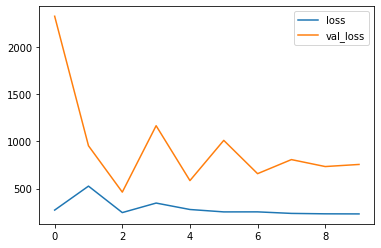

6/6 [==============================] - 0s 2ms/step


[755.9246288537979, 0.3333333432674408]

In [113]:
veinModel = Sequential()

veinModel.add(Dense(14, activation='sigmoid', input_dim=3161))
veinModel.add(Dense(2, activation='sigmoid'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
veinModel.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy']) 

veinHistory=veinModel.fit(inputs_train, targets_train,
          epochs=10,
          batch_size=400,
          verbose=1,
          validation_data=(inputs_test, targets_test),                  
          callbacks=[plot_losses])

score = veinModel.evaluate(inputs_test, targets_test, batch_size=1)
score 
